<a href="https://colab.research.google.com/github/Whaleman0423/class_no.4_paper/blob/main/Stealmodel_video_scooter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 遷移學習 VGG16 套用已裁切後的 競戰六代和 gogoro S2

In [35]:
##### 載入雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
#, weights='imagenet'
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
import glob
import pandas as pd
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大集合_未去背_未套背/GOGORO_S2_已裁減/*.jpg"):
  s = pd.Series([p, 1], index=["path", "target"])
  df = df.append(s, ignore_index=True)
for p in glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大集合_未去背_未套背/YAMAHA_六代競戰_125_已裁減/*.jpg"):
  s = pd.Series([p, 0], index=["path", "target"])
  df = df.append(s, ignore_index=True)
df

,path,target
0,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,1
1,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,1
2,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,1
3,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,1
4,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,1
...,...,...
625,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,0
626,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,0
627,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,0
628,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪後_全款大...,0


In [38]:
from tensorflow.keras.preprocessing.image import load_img
import random
c = random.randint(0, 629)
# print(df["path"][c])
# img = load_img(df["path"][c], target_size=(224, 224))
# print(img.size)
# img

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

for l in vgg.layers:  
  l.trainable = False
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(units=2048, activation="selu")(x)
x = Dense(units=512, activation="selu")(x)
x = Dense(units=64, activation="selu")(x)
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [40]:
cnn.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
            )

In [41]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

y_cat = to_categorical(df["target"])

import numpy as np
x_train, x_test, y_train, y_test = train_test_split(
                                np.array(df["path"]),
                                np.array(y_cat),
                                test_size=0.1      
                                       )
y_train[0]

array([0., 1.], dtype=float32)

In [46]:
from tensorflow.keras.applications.vgg16 import preprocess_input

batch_size = 7
for i in range(5):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imglist = []
  for fn in x_train[idx]:
    img = load_img(fn, target_size=(224, 224))
    img = preprocess_input(np.array(img))
    imglist.append(img)
  x = np.array(imglist)
  y = y_train[idx]
  result = cnn.train_on_batch(x, y)
  print("-------------Times", i,"---------------")
  print(result)

-------------Times 0 ---------------
[16.366785049438477, 0.7285714149475098]
-------------Times 1 ---------------
[0.6817671060562134, 1.0]
-------------Times 2 ---------------
[4.605616777553223e-05, 1.0]
-------------Times 3 ---------------
[1.1760413217108822e-19, 1.0]
-------------Times 4 ---------------
[3.735628366470337, 0.7142857313156128]


In [47]:
batch_size = 63

idx = np.random.randint(0, x_test.shape[0], batch_size)
imglist = []
oriimglist = []
for fn in x_test[idx]:
  img = load_img(fn, target_size=(224, 224))
  oriimglist.append(img)
  img = preprocess_input(np.array(img))
  imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)


2/2 [==============================] - 0s 254ms/step - loss: 4.5788 - accuracy: 0.9683


[4.578805923461914, 0.9682539701461792]

In [50]:
pre = cnn.predict(x).argmax(axis=-1)
pre

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0])

In [51]:
y.argmax(axis=-1)

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [52]:
np.nonzero(pre != y.argmax(axis=-1))

(array([22, 54]),)

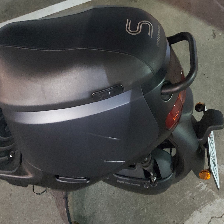

In [55]:
oriimglist[22]

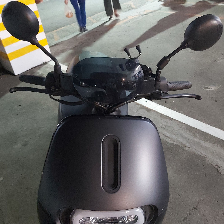

In [56]:
oriimglist[54]